## Exploration 11

### STEP 1 : 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [3]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


### STEP 2 : 각종 전처리 수행
* 결측치 처리
* 로그 변환

In [4]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

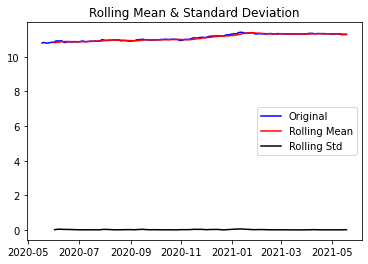

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


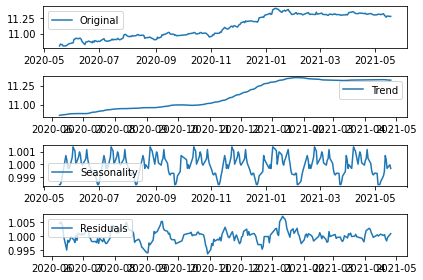

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

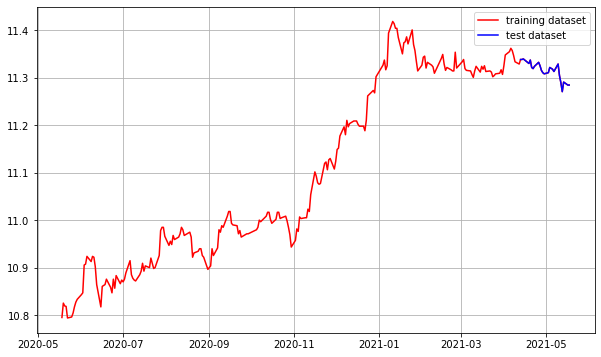

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


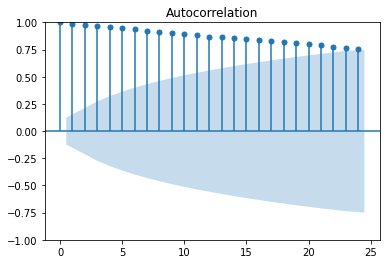

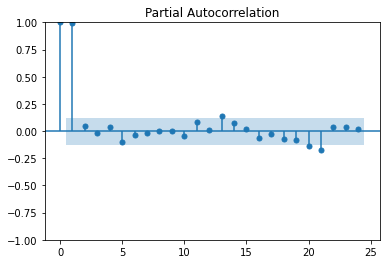

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


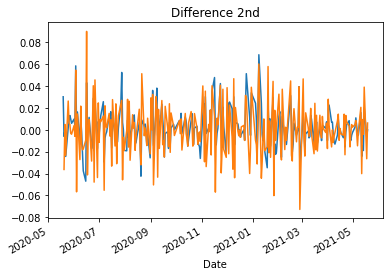

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        05:34:43   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


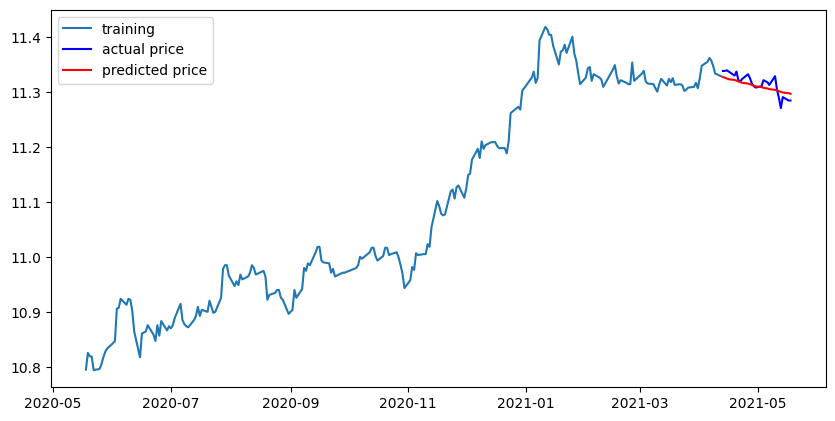

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### STEP 7 : 다른 주식 종목 예측해 보기
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

슝=3
슝=3


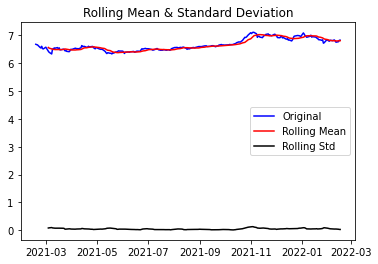

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


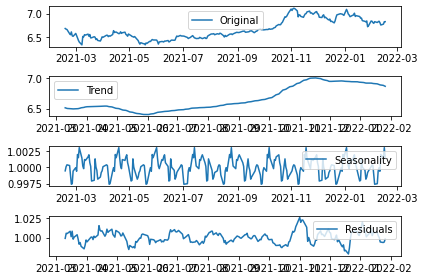

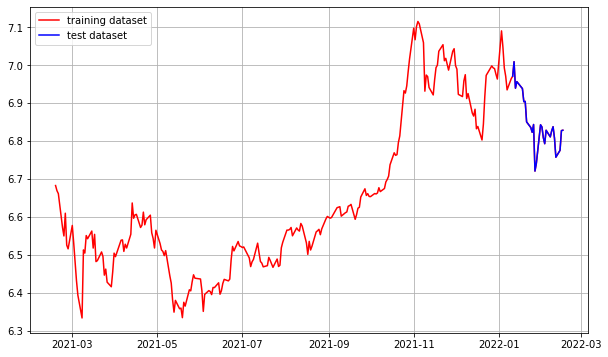

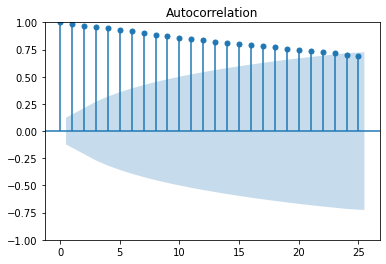

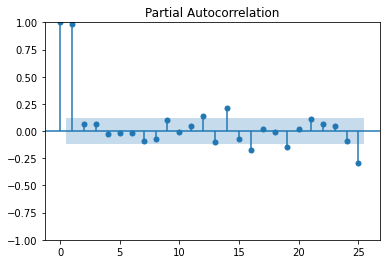

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 438.882
Date:                Thu, 17 Feb 2022   AIC                           -863.764
Time:                        14:31:44   BIC                           -839.820
Sample:                             0   HQIC                          -854.101
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2656      0.071     -3.758      0.000      -0.404      -0.127
ar.L2         -0.9064      0.051    -17.642      0.000      -1.007      -0.806
ar.L3          0.0089      0.072      0.124      0.9

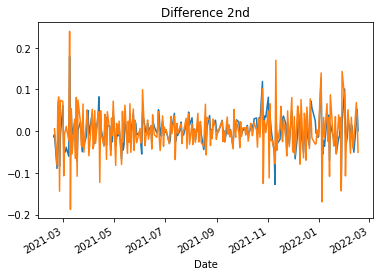

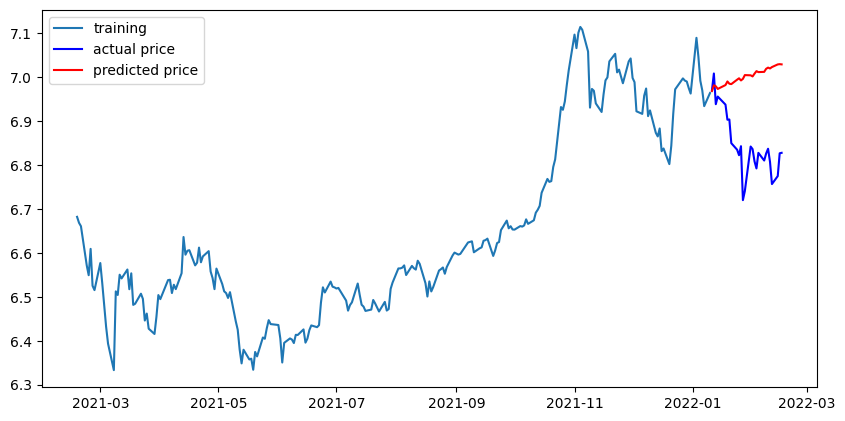

MSE:  31256.277580091213
MAE:  158.8283154022858
RMSE:  176.79445008283267
MAPE: 17.48%
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-700.784, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-773.937, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-702.781, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-805.622, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-812.161, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-853.395, Time=0.59 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-854.883, Time=0.74 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-858.155, Time=1.22 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=1.11 sec

Best model:  ARIMA(3,2,3)(0,0,0)[0]

ARIMA(order=(3, 2, 3), scoring_args={}, suppress_warnings=True)

In [12]:
# CASE 1 : 미국주식 - 테슬라

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')


from statsmodels.tsa.stattools import adfuller
# p value를 확인하기 위한 과정인 값이 0에 가까워야 좋다.

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')


# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(3, 2, 3))  # order = (p, d, q) 
fitted_m = model.fit() 

print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

###########################
# 오토 아리마
import FinanceDataReader as fdr
from pmdarima.arima import ndiffs
import pmdarima as pm

# train 데이터로 학습 및 test 데이터로 예측
model = pm.auto_arima(y = train_data        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

model = pm.auto_arima (train_data, d = 2, seasonal = False, trace = True)
model.fit(train_data)
########################################

* p=2, d=0, q=1 -> MAPE: 8.52%
* p=2, d=1, q=0 -> MAPE: 13.00%
* p=2, d=1, q=1 -> MAPE: 12.99%
* p=1, d=2, q=0 -> MAPE: 23.61%
* p=1, d=2, q=1 -> MAPE: 16.34%
* p=0, d=2, q=1 -> MAPE: 16.00%
* p=1, d=0, q=2 -> MAPE: 8.56%
* p=0, d=1, q=2 -> MAPE: 13.00%
* p=1, d=1, q=2 -> MAPE: 13.00%


* p=3, d=2, q=3 -> MAPE: 17.48%

슝=3
슝=3


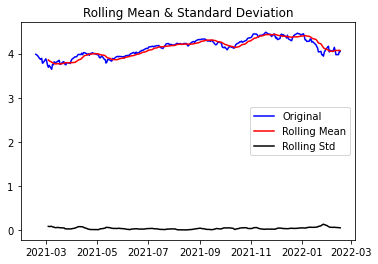

Results of Dickey-Fuller Test:
Test Statistic                  -1.525992
p-value                          0.520616
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.255688
p-value                          0.000007
#Lags Used                      14.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


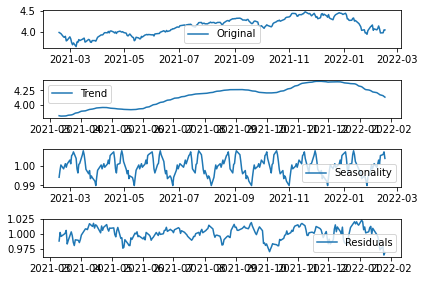

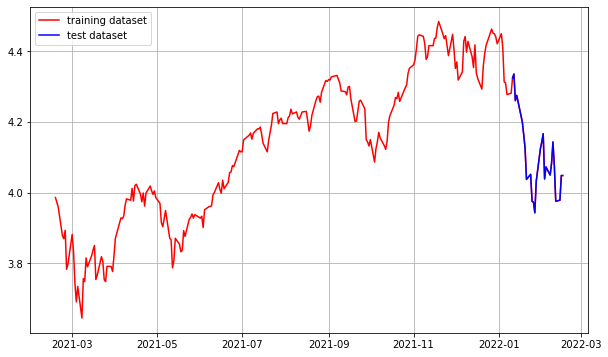

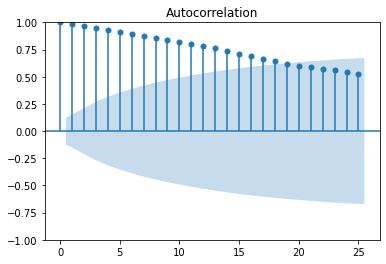

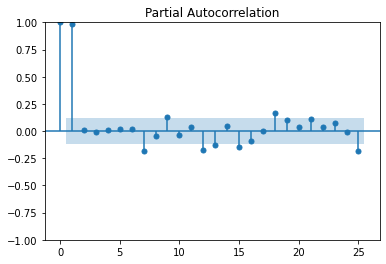

Results of Dickey-Fuller Test:
Test Statistic                -1.614895e+01
p-value                        4.591278e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.902518e+00
p-value                        4.148631e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 440.087
Date:                Thu, 17 Feb 2022   AIC                           -872.174
Time:                        14:35:12   BIC                           -858.492
Sample:                             0   HQIC                          -866.652
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0531      0.067     -0.791      0.429      -0.185       0.078
ar.L2         -0.0371      0.048     -0.766      0.444      -0.132       0.058
ma.L1         -0.9949      0.068    -14.644      0.0

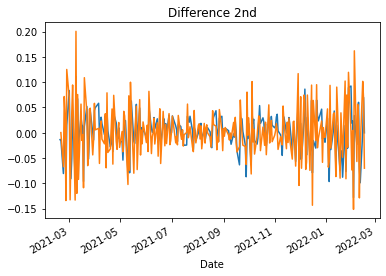

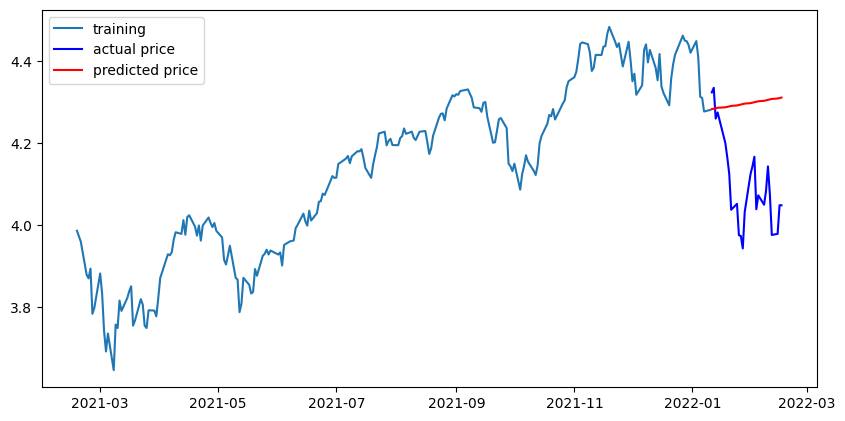

MSE:  212.1483297753308
MAE:  13.223916994125709
RMSE:  14.565312553300421
MAPE: 23.03%
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-712.528, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-777.491, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-714.527, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-807.104, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-828.661, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-864.085, Time=0.65 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-869.265, Time=0.31 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-866.361, Time=0.77 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]

ARIMA(order=(2, 2, 1), scoring_args={}, suppress_warnings=True)

In [14]:
# CASE 2 : 미국 3배 레버리지 ETF - TQQQ

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TQQQ.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')


from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')


# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 2, 1))  # order = (p, d, q) 
fitted_m = model.fit() 

print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

###########################
# 오토 아리마
import FinanceDataReader as fdr
from pmdarima.arima import ndiffs
import pmdarima as pm

# train 데이터로 학습 및 test 데이터로 예측
model = pm.auto_arima(y = train_data        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

model = pm.auto_arima (train_data, d = 2, seasonal = False, trace = True)
model.fit(train_data)
########################################

* p=2, d=0, q=1 -> MAPE: 19.11%
* p=2, d=1, q=0 -> MAPE: 21.12%
* p=2, d=1, q=1 -> MAPE: 21.17%
* p=1, d=2, q=0 -> MAPE: 8.14%
* p=1, d=2, q=1 -> MAPE: 23.20%
* p=0, d=2, q=1 -> MAPE: 23.21%
* p=1, d=0, q=2 -> MAPE: 18.34%
* p=0, d=1, q=2 -> MAPE: 21.15%
* p=1, d=1, q=2 -> MAPE: 21.04%

슝=3
슝=3


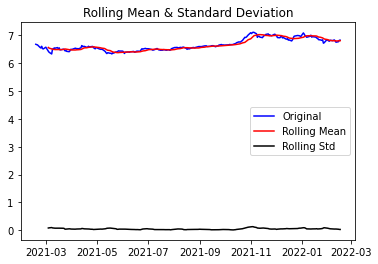

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


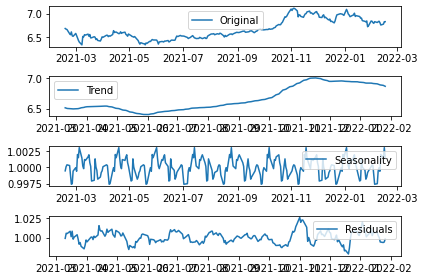

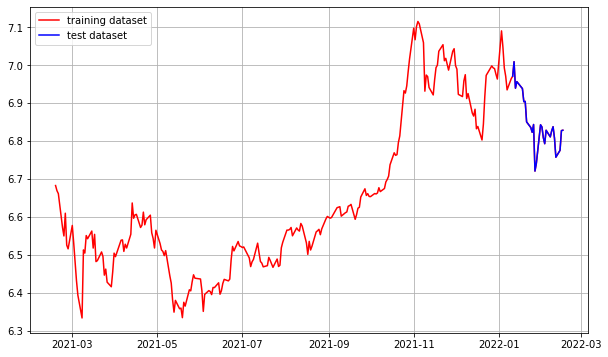

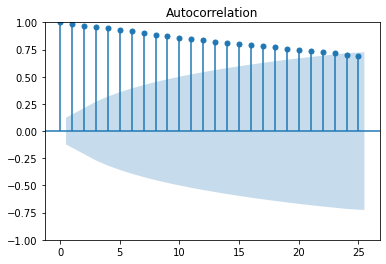

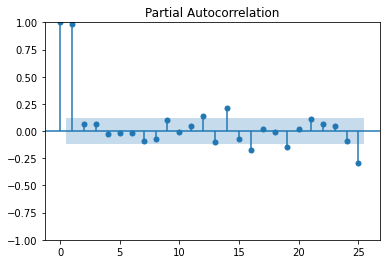

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 438.882
Date:                Thu, 17 Feb 2022   AIC                           -863.764
Time:                        14:34:17   BIC                           -839.820
Sample:                             0   HQIC                          -854.101
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2656      0.071     -3.758      0.000      -0.404      -0.127
ar.L2         -0.9064      0.051    -17.642      0.000      -1.007      -0.806
ar.L3          0.0089      0.072      0.124      0.9

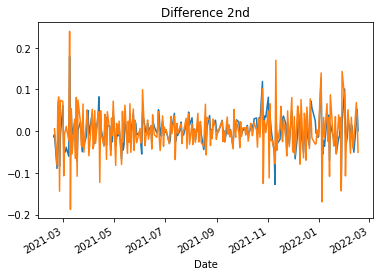

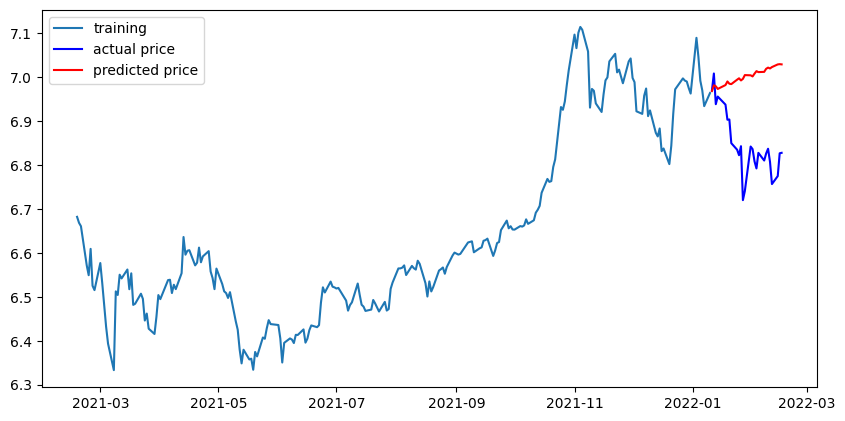

MSE:  31256.277580091213
MAE:  158.8283154022858
RMSE:  176.79445008283267
MAPE: 17.48%
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-700.784, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-773.937, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-702.781, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-805.622, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-812.161, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-853.395, Time=0.33 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-854.883, Time=0.52 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-858.155, Time=1.24 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=1.23 sec

Best model:  ARIMA(3,2,3)(0,0,0)[0]

ARIMA(order=(3, 2, 3), scoring_args={}, suppress_warnings=True)

In [13]:
# CASE 3 : 미국 3배 레버리지 ETF - LABU

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')


from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')


# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)


# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(3, 2, 3))  # order = (p, d, q) 
fitted_m = model.fit() 

print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

###########################
# 오토 아리마
import FinanceDataReader as fdr
from pmdarima.arima import ndiffs
import pmdarima as pm

# train 데이터로 학습 및 test 데이터로 예측
model = pm.auto_arima(y = train_data        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

model = pm.auto_arima (train_data, d = 2, seasonal = False, trace = True)
model.fit(train_data)
########################################

* p=2, d=0, q=1 -> MAPE: 8.52%
* p=2, d=1, q=0 -> MAPE: 13.00%
* p=2, d=1, q=1 -> MAPE: 12.99%
* p=1, d=2, q=0 -> MAPE: 23.61%
* p=1, d=2, q=1 -> MAPE: 16.34%
* p=0, d=2, q=1 -> MAPE: 16.00%
* p=1, d=0, q=2 -> MAPE: 8.56%
* p=0, d=1, q=2 -> MAPE: 13.00%
* p=1, d=1, q=2 -> MAPE: 13.00%


# 📕 회고  + AutoARIMA

* 해당 노드는 p, d, q를 조절해서 MAPE 값을 낮추는 것이 목적<br>
    → 각 CASE의 가장 낮은 MAPE 값을 확인<br>
    (예측오차가 가장 작은 값을 찾는 과정)
<br><br>
* MSE와 MAPE는 회귀분석에서 사용하는 성능지표.
    MSE의 범위는 0~무한대(infinity)의 값을 가진다.
    MSE가 100이다 했을 때 이 모형이 좋은지 판단하기가 어려움 그래서 MAPE의 퍼센트 값을 통해 성능평가.
    MAPE은 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음.
<br><br>
* AR -> MA -> ARMA -> ARIMA 순서대로 기법이 발전<br>
    ARIMA = AR + I + MA
<br><br>
* p : 자기회귀 모형(AR)의 시차<br>
    d : 차분 누적(I) 횟수<br>
    q : 이동평균 모형(MA)의 시차
<br><br>
* 노드에서 제시한 기준은 다음과 같다.<br>
    p+q < 2 , p * q = 0<br>
    그러나 p * q = 1이 되었을 때 MAPE값이 낮게 나오는 경우도 있었음.
<br><br>
* 가능한 파라미터의 경우의 수가 많아졌을 때, 일일이 직접 바꿔야 하는 수고로움을 덜고 싶었다.<br>
또 노드에서 제시한 기준과는 다른 조건에서 MAPE값이 낮게 나오는 경우도 있었기 때문에 가능하면 다른 조건도 함께 검토하고 싶었다.<br>
두 가지 모두를 해결할 방법을 찾다가 오토아리마를 알게 되었다.
<br><br><br>
### auto arima<br>
    : d(차원)을 지정하면 최적의 MAPE가 나오는 파라미터 값을 자동으로 찾아준다.<br>

**참고**<br>
https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/<br>

**결과**<br>
오토아리마에서 d(차원)값의 기본값은 None이다.<br>
d에 정수 n을 넣어주면 n까지의 모든 경우의 수에서 최적조합을 계산해 보여준다<br>
숫자가 커질수록 실행시간이 오래 걸릴 수 있다.<br>
<br>
오토아리마는 각 CASE에서 다음과 같은 값을 보여줬다.<br>

<img width="300" alt="autoarima" src="https://user-images.githubusercontent.com/96965899/154502304-0cf9f3f8-0d35-480e-9f5e-cd7475513772.png">
    
<br>
오토아리마가 알려준 조합을 넣어 코드를 실행시켰다.<br>
각 CASE의 가장 낮은 MAPE의 값은 오토아리마가 알려준 값임을 기대했으나, CASE 1과 CASE 3의 경우에는 17.48%, CASE 2의 경우는  23.03%로 다른 경우의 수 보다 높은 수치가 나왔다.<br>
왜 오토아리마가 특정 조합을 뽑아냈는지, 어째서 그 조합이 최적의 값이 아니었는지는 추후 더 알아봐야 할 것 같다.<br>
이 과정을 진행하면서 오토아리마와 같이 최적의 모델을 위해 사용되는 모델도 신뢰성을 반드시 검증해야 한다는 것을 생각해보게 되었다.<br>


추정된 차수 d = 1
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5114.500, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5089.241, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5071.627, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5112.511, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5042.956, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5044.199, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5048.906, Time=0.46 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5077.561, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5051.846, Time=0.77 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0] intercept
Total fit time: 2.873 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4942.230, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=

'\n# Step 3. 잔차 검정\n# 잔차가 백색잡음 과정인지 (=정상성을 만족하는지), 정규성 및 등분산성을 만족하는지 파악\n\nprint(model.summary())\n\nmodel.plot_diagnostics(figsize=(16, 8))\nplt.show()\n\n\n\n\n# Step 4. 모형 refresh 및 예측\n# 테스트 데이터 예측\n\n# 테스트 데이터 개수만큼 예측\ny_predict = model.predict(n_periods=len(y_test)) \ny_predict = pd.DataFrame(y_predict,index = y_test.index,columns=[\'Prediction\'])\n\n# 그래프\nfig, axes = plt.subplots(1, 1, figsize=(12, 4))\nplt.plot(y_train, label=\'Train\')        # 훈련 데이터\nplt.plot(y_test, label=\'Test\')          # 테스트 데이터\nplt.plot(y_predict, label=\'Prediction\')  # 예측 데이터\nplt.legend()\nplt.show()\n\n\n\ndef forecast_one_step():\n    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!\n        , return_conf_int=True)              # 신뢰구간 출력\n    return (\n        fc.tolist()[0],\n        np.asarray(conf_int).tolist()[0]\n    )\n\n\nforecasts = []\ny_pred = []\npred_upper = []\npred_lower = []\n\nfor new_ob in y_test:\n    fc, conf = forecast_one_step()\n    y_pred.append(fc)\n    pred_upper.app

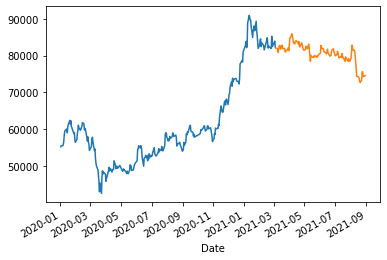

In [3]:
"""
# 오토 아리마 전체코드

# !pip install finance-datareader
# !pip install -U finance-datareader # 업데이트

import FinanceDataReader as fdr
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm




# 삼성전자 주가로 ARIMA 최적 모델 찾기
# 20년 1월부터 21년 8월 30일까지의 일별 삼성전자 주가 데이터
df_krx = fdr.StockListing('KRX') # 한국거래소 상장종목 전체
ticker = df_krx[df_krx.Name=='삼성전자']['Symbol'] # 티커
ss = fdr.DataReader(''.join(ticker.values),'2020-01-01', '2021-08-30')



# Step 1. 시계열 자료 시각화 
# 7:3의 비율로 train과 test 데이터를 나누기
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]
y_train.plot()
y_test.plot()

# 정말 차분이 필요한지, 필요하다면 몇 차 차분이 최선인지 파악
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")



# Step 2. ARIMA 모형 적합
# train 데이터로 학습 및 test 데이터로 예측
model = pm.auto_arima(y = y_train        # 데이터
                      , d = 2            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )


model = pm.auto_arima (y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)
"""



"""
# Step 3. 잔차 검정
# 잔차가 백색잡음 과정인지 (=정상성을 만족하는지), 정규성 및 등분산성을 만족하는지 파악

print(model.summary())

model.plot_diagnostics(figsize=(16, 8))
plt.show()




# Step 4. 모형 refresh 및 예측
# 테스트 데이터 예측

# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()



def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )


forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)
    

pd.DataFrame({"test": y_test, "pred": y_pred})

print(model.summary())



from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()





# Step 5. 모형 평가
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")
# MAPE: 0.792

"""